## <b> Setup <b/>

### <b> Colab <b/>

In [1]:
colab = False

if colab:
    
    PROJECT_NAME = ''
    if colab & (PROJECT_NAME==''): raise ValueError('Please modify PROJECT_NAME for running on Colab')
    
    ### Access Google Drive

    from google.colab import drive
    drive.mount('/content/gdrive')

    ### Access GCS

    from google.colab import auth
    auth.authenticate_user()

    ### Mount the directories

    import os

    # Mount the data directory
    os.chdir(f'/content/gdrive/MyDrive/LinuxServer-Bob/Code/Project/{PROJECT_NAME}/src')
    os.symlink('/content/gdrive/MyDrive/LinuxServer-Bob/Data', '/data')
    print(f"PWD: {os.getcwd()}")

    # Mount the tfrecord directory
    gcs_path = "gs://bobscchien-project-data"

    ### Install packages

    !pip3 install -r '../requirements.txt'


### Check the computation resources

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)

Thu Mar  3 16:49:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:07:00.0  On |                  N/A |
|  0%   53C    P3    35W / 170W |    865MiB / 12052MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### <b> Initialization <b/>

In [2]:
### setup parent directory path 

import sys

sys.path.append('..')
sys.path.append('../src')

### initialization

from utils.initialization import *

if colab:
    DIR_VOCAB       = os.path.join(gcs_path, 'Text_Tokenizer', 'vocab')
    DIR_TOKEN       = os.path.join(gcs_path, 'Text_Tokenizer', 'trained')

    DIR_TFRECORD    = os.path.join(gcs_path, PROJECT_NAME, 'data', 'processed')
    DIR_MODEL       = os.path.join(gcs_path, PROJECT_NAME, 'models', 'savedmodels')
    DIR_CHECKPOINT  = os.path.join(gcs_path, PROJECT_NAME, 'models', 'checkpoints')
    DIR_LOG         = os.path.join(gcs_path, PROJECT_NAME, 'models', 'logs')

Directory /data/Model_Tensorflow exists.
Directory /data/Model_Pytorch exists.
Directory ../models/tokenizers exists.
Directory /data/Text_Summarizer/data exists.
Directory /data/Text_Summarizer/models exists.
Directory ../models/tokenizers/data/vocab exists.
Directory ../models/tokenizers/models/trained exists.
Directory /data/Text_Summarizer/data/raw exists.
Directory /data/Text_Summarizer/data/intermin exists.
Directory /data/Text_Summarizer/data/processed exists.
Directory /data/Text_Summarizer/models/savedmodels exists.
Directory /data/Text_Summarizer/models/checkpoints exists.
Directory /data/Text_Summarizer/models/logs exists.

Running on GPU...

Your runtime has 101.1 gigabytes of available RAM

You are using a high-RAM runtime!


2022-03-03 16:49:40.384709: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-03 16:49:40.391385: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-03 16:49:40.392106: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-03 16:49:40.393239: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

## <b> 1. Load Dataset <b/>

In [3]:
from make_dataset import *

train_texts, train_labels = pd.read_csv(os.path.join(DIR_INTERMIN, lang, 'train.zip'))[['source', 'target']].dropna().values.T.tolist()
valid_texts, valid_labels = pd.read_csv(os.path.join(DIR_INTERMIN, lang, 'valid.zip'))[['source', 'target']].dropna().values.T.tolist()
test_texts, test_labels = pd.read_csv(os.path.join(DIR_INTERMIN, lang, 'test.zip'))[['source', 'target']].dropna().values.T.tolist()

### demo

for name, data in zip(['Training', 'Validation', 'Testing'], [train_texts, valid_texts, test_texts]):
    print(f"Number of {name} Data :", len(data))
    
for text, label in zip(test_texts[-20:], test_labels[-20:]):
    print(f'\nReview: {text}')
    print(f'\nLabel : {label}')
    print('\n', '=' * 50)

Number of Training Data : 389998
Number of Validation Data : 5000
Number of Testing Data : 5000

Review: 週六，兩對極其熱愛培根的夫婦共同在愛荷華州的ｄｅｓｍｏｉｎｅｓ舉辦了婚禮，婚禮以培根為主題，宣誓時雙方均表示，要與愛人共享“美好時光和培根”。婚禮在當地的“藍絲帶培根節”當天舉辦，許多前來參加培根節的人也前來參加。

Label : 愛你就像愛培根！美國兩對吃貨共同舉辦培根婚禮


Review: 民主開言路，協商凝共識。人民政協作為中國人民愛國統一戰線的組織、中國共產黨領導的多黨合作和政治協商的重要機構、我國政治生活中發揚社會主義民主的重要形式，是各黨派團體和各族各界人士發揚民主、參與國是、團結合作的重要平臺。

Label : 民主廣開言路協商凝聚共識


Review: 中央紀委監察部網站１７日訊息，經查，丁寶軍利用職務上的便利為他人謀取利益，收受賄賂，數額巨大；收受禮金；與一名女性長期保持不正當兩性關係。決定給予丁寶軍開除黨籍處分，並按規定依法辦理開除公職手續。

Label : 安徽省煤田地質局原副局長丁寶軍被開除黨籍


Review: 當都市麗人董事長鄭耀南牽著志玲姐姐在推介會上宣佈從６月１６日起招股募資近１８億港元，都市麗人２６日將在聯交所主機板掛牌上市時。這位保安出身、從賣襪子、賣文胸起家的農家少年終於華麗的成功逆襲為高富帥。

Label : 林志玲為內衣股都市麗人造勢赴港認購遇冷


Review: 一方面，是民間投資渠道的匱乏，一方面，是打著高收益旗號的投資公司。當這類機構如雨後春筍般不斷冒出的時候，利益驅動也使得普通市民在知情或不知情的前提下成為其中一環。即使風險已經暴露，但身在其中難以退出的現實也成為一大阻礙。

Label : 民間借貸擊鼓傳花花砸誰家


Review: 僅一年光景，就有４２名涉貪涉腐的省部級高官落馬，中紀委當之無愧地成為全中國最受關注的“有關部門”。近日，中紀委網站公佈了一個“驚人”的資料，該網站全年的點選量已經超過９．７億次！若換算成廣告投放相當於４８５萬元。

Label : ２０１４年中紀委網站點選量破９．７億若投放廣告估價４８５萬


Review: １１月１９日劉豔從幼兒園接小毛回家發現他臉上有紅掌印

## <b> 2. Load Tokenizer & TFRecord <b/>

In [4]:
from make_tfrecord import *

# setup dataset parameters
BUFFER_SIZE = 400000
BATCH_SIZE = 64
GLOBAL_BATCH_SIZE = BATCH_SIZE * strategy.num_replicas_in_sync

# load tfrecord
train_batches = loadTFRecord('train', os.path.join(DIR_TFRECORD, lang), GLOBAL_BATCH_SIZE, BUFFER_SIZE)
valid_batches = loadTFRecord('valid', os.path.join(DIR_TFRECORD, lang), GLOBAL_BATCH_SIZE)
test_batches = loadTFRecord('test',   os.path.join(DIR_TFRECORD, lang), GLOBAL_BATCH_SIZE, cache=False)

for demo in test_batches.take(1):
    print(demo)


Using Pretrained Bert Model: {'inp': 'ckiplab/albert-tiny-chinese', 'tar': None}
Cache Directory of Model: {'inp': '/data/Model_Pytorch/ckiplab/albert-tiny-chinese', 'tar': None}

Max Length of Text: {'inp': 256, 'tar': 64}
zh Vocabulary Size : 21128
zh Vocabulary Size : 10362
((<tf.Tensor: shape=(64, 137), dtype=int32, numpy=
array([[ 101, 4245, 7621, ...,    0,    0,    0],
       [ 101, 3791, 1751, ...,    0,    0,    0],
       [ 101, 8029, 3299, ...,    0,    0,    0],
       ...,
       [ 101, 7442, 3975, ...,    0,    0,    0],
       [ 101, 8034, 3299, ...,    0,    0,    0],
       [ 101, 8029,  510, ...,    0,    0,    0]], dtype=int32)>, <tf.Tensor: shape=(64, 137), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>), <tf.Tensor: shape=(64, 32), dtype=int32, numpy=
array([[  2, 357, 628, .

## <b> 3. Model Training & Evaluation <b/>

### <b> Modeling <b/>


 {'predictions': Value(dtype='string', id='sequence'), 'references': Value(dtype='string', id='sequence')}

Number of Samples: 389992

warmup_steps: 60940


2022-03-03 16:50:05.492434: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFAlbertModel: ['predictions.LayerNorm.weight', 'predictions.bias', 'predictions.dense.bias', 'predictions.decoder.weight', 'predictions.decoder.bias', 'predictions.dense.weight', 'albert.embeddings.position_ids', 'predictions.LayerNorm.bias']
- This IS expected if you are initializing TFAlbertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFAlbert

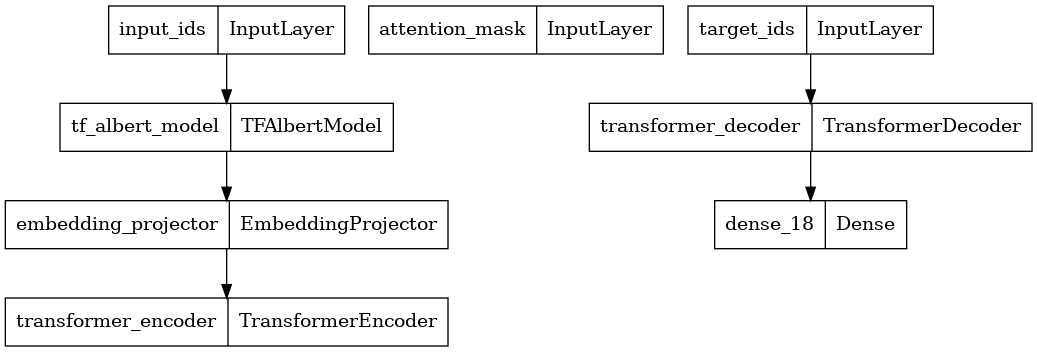

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, None)]       0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 tf_albert_model (TFAlbertModel  TFBaseModelOutputWi  4080520    ['input_ids[0][0]',              
 )                              thPooling(last_hidd               'attention_mask[0][0]']         
                                en_state=(None, Non                                               
                                e, 312),                                                    

In [5]:
from model_training import *

### <b> Training <b/>

In [6]:
if colab:
    %load_ext tensorboard
    %tensorboard --logdir {DIR_LOG}

In [ ]:
%%time

history = model.fit(train_batches.repeat(EPOCHS), validation_data=valid_batches,
                    initial_epoch=last_epoch, epochs=EPOCHS, steps_per_epoch=steps_per_epoch, callbacks=callbacks)

Epoch 1/100
6094/6094 [==============================] - ETA: 0s - loss: 6.6790 - accuracy: 0.1071
    Input: 營 養 改 善 計 劃 啟 動 之 初 ， 公 眾 和 輿 論 就 已 準 確 預 估 了 將 來 可 能 出 現 的 問 題 。 須 防 貪 腐 之 手 ， 要 清 除 利 益 鏈 條 ， 微 博 時 代 ， 一 定 要 形 成 公 開 、 透 明 、 及 時 、 高 效 的 社 會 監 督 互 動 模 式 ， 時 至 今 日 ， 回 想 這 種 驚 人 的 預 見 性 實 讓 人 五 味 雜 陳 。
    Target: 級 協 父 立 沒 析 機 有 反 球 稱 [UNK]
    Predict: 到 傳 到 傳 到 傳 到 傳 到 最

    Input: ５７ 歲 的 法 國 人 阿 蘭 － 佩 林 將 成 國 足 新 帥 ， 率 領 男 足 衝 擊 ２０１５ 年 亞 洲 盃 。 佩 林 長 期 在 西 亞 海 灣 執 教 ， 熟 悉 和 了 解 亞 洲 足 球 。 據 悉 年 薪 在 １００ 萬 美 元 以 內 。 他 預 計 在 明 天 抵 達 清 遠 與 國 足 會 合 ， 然 後 隨 隊 前 往 迪 拜 備 戰 與 伊 拉 克 亞 預 賽 。
    Target: 人 養 來 與 繁 [UNK] 作 人 些 翻 根 早 [UNK] 摔 停
    Predict: 現 人 [UNK] 在 [UNK] [UNK] [UNK] 名 現 人 [UNK] 名 現 ７

    Input: 法 國 知 名 報 紙 《 世 界 報 》 日 前 宣 稱 ， 法 國 情 報 部 門 對 外 安 全 總 局 也 正 在 執 行 類 似 專 案 ， 即 監 聽 民 眾 的 電 子 通 訊 資 料 。 《 世 界 報 》 稱 ， 對 外 安 全 總 局 擁 有 巨 大 的 電 子 監 聽 體 系 ， 收 集 電 腦 和 手 機 的 資 料 資 訊 ， 監 控 法 國 國 內 及 對 外 的 通 訊 活 動 。
    Target: 作 ｙ 承 給 作 人 察 鰲 珠 十 度
    Predict: 作 人 內 管 內 管 到 最 內 管 合

Epoch 1/100
4531/4531 [==============================] - ETA: 0s - loss: 6.9379 - accuracy: 0.0786
    Input: 近 日 ， 有 網 友 反 映 ， 黑 龍 江 移 動 公 司 疑 似 私 自 為 客 戶 套 送 增 值 付 費 套 餐 ， 這 些 業 務 並 沒 有 經 過 客 戶 的 主 觀 同 意 。 舉 報 問 題 的 網 友 認 為 ， 其 個 人 資 訊 的 安 全 受 到 了 嚴 重 威 脅 。 對 此 ， 移 動 公 司 表 示 正 在 調 查 ， 並 將 於 14 日 給 出 回 覆 。
    Target: 中 移 動 被 爆 私 自 增 減 客 戶 業 務 迴 應 稱 正 調 查
    Predict: 廣 州 [UNK] 年 [UNK] 個 月 [UNK] 萬

    Input: 截 至 2013 年 9 月 30 日 的 六 個 月 裡 ， 銷 售 收 入 617 億 日 元 ( 6. 26 億 美 元 ) ， 同 比 增 長 1 % 。 然 而 淨 收 入 方 面 的 增 長 更 為 突 出 ， 去 年 同 期 該 公 司 還 處 於 虧 損 狀 態 ， 而 今 年 則 從 原 來 的 55 億 日 元 ( 5600 萬 美 元 ) 虧 損 轉 成 了 26 億 日 元 ( 2600 萬 美 元 ) 的 盈 利 。
    Target: 扭 虧 為 盈 [UNK] 上 半 財 年 收 6 . [UNK] 億 美 元
    Predict: [UNK] 億 美 元 [UNK] 億 美 元

    Input: 網 際 網 路 對 裝 修 使 用 者 的 影 響 ， 造 就 了 網 際 網 路 對 家 居 行 業 的 影 響 。 齊 家 網 做 了 很 多 工 作 。 主 要 分 成 兩 部 分 ： 一 部 分 圍 繞 網 際 網 路 思 維 ， 把 體 驗 、 極 致 、 創 新 做 透 。 第 二 部 分 圍 繞 著 家 居 ， 通 過 團 購 、 商 城 、 體 驗 館 形 成 了 齊 家 2 模 式 。
    Target: 2 案 例 : 齊 家 如 何 應 對 2 帶 來 的 家 居 變 革
    Predi

### <b> Evaluation <b/>

In [8]:
%%time

### measure the performance

for dataset in tqdm.tqdm(test_batches):
    inp_list, tar_list, pred_list = predict_step(model, dataset)

if 'bleu' in score_name:
    text_scores = text_metric.compute(lowercase=True)
    text_score = text_scores['score']
elif 'rouge' in score_name:
    text_scores = text_metric.compute()
    text_score = text_scores['rouge1'].mid.fmeasure

score = f"{score_name}-{text_score:.6f}"
print('\nModel Score:', score)

78it [15:15, 11.73s/it]



Model Score: rouge-0.314779
CPU times: user 14min 56s, sys: 1.28 s, total: 14min 58s
Wall time: 15min 16s


### <b> Export <b/>

In [9]:
### Create and save the predictor

config_detail = f"{model_name}_{score}_{run_id}"
predictor = HF2TFSeq2SeqExporter(model, tokenizers, BOS_IDS, beam_params, sampler_params,
                                 bert_names, config_detail, lang, lang)
predictor_dir = os.path.join(DIR_MODEL, f"{model_name}_{score}")
tf.saved_model.save(predictor, export_dir=predictor_dir)

2022-03-03 14:45:11.336734: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


## <b> 4. Inference <b/>

In [10]:
from utils.servitization import HF2TFSeq2SeqPipeline
from utils.callback import print_seq2seq
from utils.visualization import plot_attention_weights

In [11]:
### Reload the pipeline to verify the result

text_preprocessors = {'inp': preprocessors[lang], 'tar': preprocessors[lang]}
pretrain_dir = DIR_MODELTORCH

pipeline = HF2TFSeq2SeqPipeline(predictor_dir, pretrain_dir, text_preprocessors)

### <b> Sentence <b/>

In [12]:
sentences = [
    "朋友買了一件衣料，綠色的底子帶白色方格，當她拿給我們看時，一位對圍棋十分感與趣的同學說：「啊，好像棋盤似的。」",
    "「我看倒有點像稿紙。」我說。「真像一塊塊綠豆糕。」一位外號叫「大食客」的同學緊接著說。",
    "我們不禁哄堂大笑，同樣的一件衣料，每個人卻有不同的感覺。那位朋友連忙把衣料用紙包好，她覺得衣料就是衣料，不是棋盤，也不是稿紙，更不是綠豆糕。",
    "JoJo的奇妙冒險中出現了大量的超自然元素，也結合了真實世界的人物和事件。第一部的故事圍繞著一個只要沾上血就能將配戴者變成吸血鬼的石鬼面，而吸血鬼可以將人變成殭屍，吸血鬼和殭屍只能被太陽光或波紋氣功消滅，波紋是一種透過規律呼吸來產生能量的武術。在第二部中，出現了超古代生物柱之男，他們有著遠超過人類、吸血鬼和殭屍的力量以及壽命，但一樣不能曬到太陽光和被紫外線照射。此外、第二部還使用了納粹、人體實驗、賽博格等元素。",
    "喬斯達家族有幾個共同特徵：頸部的左後方有星形的記號（第三部追加）、魁梧高大的身形、藍色或藍綠色的瞳孔、強烈的好奇心和正義感、愛好冒險的精神、專情且幾乎短命。",    
]

In [56]:
tmp = text_preprocessors['inp']("朋友買了3G/35G一件衣料，綠色的底子帶白色方格，當她拿給我們看時，一位對圍棋十分感與趣的同學說：「啊，好像棋盤似的。」").numpy().decode()

In [57]:
tmp

'朋 友 買 了 ３ ｇ ／ ３ ５ ｇ 一 件 衣 料 ， 綠 色 的 底 子 帶 白 色 方 格 ， 當 她 拿 給 我 們 看 時 ， 一 位 對 圍 棋 十 分 感 與 趣 的 同 學 說 ： 「 啊 ， 好 像 棋 盤 似 的 。 」'

In [58]:
tokenizers.inp.encode(tmp)

[101,
 3301,
 1351,
 6525,
 749,
 8031,
 8057,
 8027,
 8031,
 8033,
 8057,
 671,
 816,
 6132,
 3160,
 8024,
 5199,
 5682,
 4638,
 2419,
 2094,
 2380,
 4635,
 5682,
 3175,
 3419,
 8024,
 4534,
 1961,
 2897,
 5183,
 2769,
 947,
 4692,
 3229,
 8024,
 671,
 855,
 2205,
 1752,
 3470,
 1282,
 1146,
 2697,
 5645,
 6637,
 4638,
 1398,
 2119,
 6303,
 8038,
 519,
 1557,
 8024,
 1962,
 1008,
 3470,
 4676,
 849,
 4638,
 511,
 520,
 102]

In [39]:
'ㄅ' in tokenizers.inp.vocab.keys()

True

In [47]:
'ｓ' in [i.decode() for i in tokenizers.tar.vocab.numpy()] #tokenize('test')

True

In [14]:
for sentence in sentences:
    target_text, target_tokens, attention_weights = pipeline(sentence, return_attention=True)
    print_seq2seq(sentence, target_text, ground_truth=None)
    print()

Input:         : 朋友買了一件衣料，綠色的底子帶白色方格，當她拿給我們看時，一位對圍棋十分感與趣的同學說：「啊，好像棋盤似的。」
Prediction     : ［ ｕ ｎ ｋ ］

Input:         : 「我看倒有點像稿紙。」我說。「真像一塊塊綠豆糕。」一位外號叫「大食客」的同學緊接著說。
Prediction     : 「 大 食 客 」 同 學 緊 接 著 說 ［ ｕ ｎ ｋ ］ 我 看 像 綠 豆 糕

Input:         : 我們不禁哄堂大笑，同樣的一件衣料，每個人卻有不同的感覺。那位朋友連忙把衣料用紙包好，她覺得衣料就是衣料，不是棋盤，也不是稿紙，更不是綠豆糕。
Prediction     : 如 何 用 紙 包 包 好 衣 料

Input:         : JoJo的奇妙冒險中出現了大量的超自然元素，也結合了真實世界的人物和事件。第一部的故事圍繞著一個只要沾上血就能將配戴者變成吸血鬼的石鬼面，而吸血鬼可以將人變成殭屍，吸血鬼和殭屍只能被太陽光或波紋氣功消滅，波紋是一種透過規律呼吸來產生能量的武術。在第二部中，出現了超古代生物柱之男，他們有著遠超過人類、吸血鬼和殭屍的力量以及壽命，但一樣不能曬到太陽光和被紫外線照射。此外、第二部還使用了納粹、人體實驗、賽博格等元素。
Prediction     : ［ ｕ ｎ ｋ ］ 的 奇 妙 冒 險

Input:         : 喬斯達家族有幾個共同特徵：頸部的左後方有星形的記號（第三部追加）、魁梧高大的身形、藍色或藍綠色的瞳孔、強烈的好奇心和正義感、愛好冒險的精神、專情且幾乎短命。
Prediction     : 喬 斯 達 家 族 的 ［ ｕ ｎ ｋ ］ 個 特 徵



Input:         : 朋友買了一件衣料，綠色的底子帶白色方格，當她拿給我們看時，一位對圍棋十分感與趣的同學說：「啊，好像棋盤似的。」
Prediction     : 買 了 一 件 衣 料 , 好 像 棋 盤 似 白 色 方 格

Input:         : 「我看倒有點像稿紙。」我說。「真像一塊塊綠豆糕。」一位外號叫「大食客」的同學緊接著說。
Prediction     : 大 食 客 : 我 看 像 綠 豆 糕

Input:         : 我們不禁哄堂大笑，同樣的一件衣料，每個人卻有不同的感覺。那位朋友連忙把衣料用紙包好，她覺得衣料就是衣料，不是棋盤，也不是稿紙，更不是綠豆糕。
Prediction     : 一 件 衣 料 , 你 知 道 嗎 ?

Input:         : JoJo的奇妙冒險中出現了大量的超自然元素，也結合了真實世界的人物和事件。第一部的故事圍繞著一個只要沾上血就能將配戴者變成吸血鬼的石鬼面，而吸血鬼可以將人變成殭屍，吸血鬼和殭屍只能被太陽光或波紋氣功消滅，波紋是一種透過規律呼吸來產生能量的武術。在第二部中，出現了超古代生物柱之男，他們有著遠超過人類、吸血鬼和殭屍的力量以及壽命，但一樣不能曬到太陽光和被紫外線照射。此外、第二部還使用了納粹、人體實驗、賽博格等元素。
Prediction     : 奇 妙 冒 險

Input:         : 喬斯達家族有幾個共同特徵：頸部的左後方有星形的記號（第三部追加）、魁梧高大的身形、藍色或藍綠色的瞳孔、強烈的好奇心和正義感、愛好冒險的精神、專情且幾乎短命。
Prediction     : 喬 斯 達 家 族 的 幾 個 共 同 特 徵

